In [1]:
# uncomment the below lines and change file paths if running in colab
# N.B. sentencepiece is only necessary for camembert
# from google.colab import drive
# drive.mount('/drive')
# !pip install transformers
# !pip install sentencepiece

## Setting up model and functions

In [ ]:
# cr loanwords = ['chanson','auteur','a la mode','académie','après','bourgeois','burlesque','depanneur','detente','ennui','faux pas','fete','fin de siecle','gite','jongleur','lycee','peloton','proletariat','rendezvous','salon']
# fr-en loanwords = ['beige','brochure','cafe','camaraderie','cliche','clique','concierge','coup','detour','elite','ensemble','etiquette','facade','fine','foyer','naive','nuance','physique','rapport','reservoir']
# literal translations = ['academy','after','author','boredom','cottage','end of century','fashionable','high school','misstep','mockery','pack','party','relaxation','repairman','room','song','minstrel','working class','meeting','middle class']
# non-borrowed words = ['fire','nose','water','tongue','blood','bone','rain','name','sweet','fly','night','ear','house','bitter','salt','knee','new','old','thick','long']
# en-fr loanwords = ['marketing','business','vintage','spoiler','casting','bestseller','pitch','cool','loser','coach','email','brunch','digital','leader','hacker','manager','jogging','yes','match','shopping']
# non-borrowed-words-fr = ['feu','nez','eau','langue','sang','os','pluie','nom','doux','mouche','nuit','oreille','maison','amer','sel','genou','nouveau','ancien','epais','long']

In [ ]:
alternative_spellings = {'a la mode':'à la mode','académie':'academie','après':'apres','depanneur':'dépanneur','détente':'detente','faux pas':'faux-pas','fete':'fête','fin de siecle':'findesiecle','gite':'gîte','lycee':'lycée','rendezvous':'rendez vous','cafe':'café','cliche':'cliché','elite':'élite','etiquette':'étiquette','facade':'façade','naive':'naïve','end of century':'end-of-century','middle-class':'middle class','bestseller':'best seller','epais':'épais'}

In [ ]:
model_name = "bert-base-uncased"
words = ['auteur','author','beige'] 
max_k = 50
language = 'en'

In [14]:
from transformers import BertTokenizer, BertForMaskedLM,CamembertForMaskedLM, CamembertTokenizer
import sentencepiece

if model_name == "camembert":
  model = CamembertForMaskedLM.from_pretrained("camembert/camembert-base-ccnet",output_hidden_states = True)
  tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-base-ccnet")

else:
  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForMaskedLM.from_pretrained(model_name,output_hidden_states = True)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [3]:
import torch

def pre_process_sentence(sentence,target_tokens):
  """
  Runs in the for loop for each sentence below
  Takes as input the sentence and the list of target tokens (before they are stripped)
  Returns a tensor with target word masked  
  """
  # Tokenise input text
  tokenized_text = tokenizer.tokenize(sentence)

  # Create attention mask
  attention_mask = [1] * len(tokenized_text)

  target_indices = []
  for item in target_tokens:
    for i in range(len(tokenized_text)):
      if tokenized_text[i:i+len(item)] == item: # making sure all the sub-tokens match
        tokens_indices = [j for j in range(i,i+len(item)) if i < (512-len(item))] # only adding indices if they are within model size
        for k in tokens_indices:
          if k not in target_indices:
            target_indices.append(k)

  for i in target_indices: # masking all the target token indices in sentence
      tokenized_text[i] = '[MASK]'
      attention_mask[i] = 0

  input_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)], dtype=torch.long)
  attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long)
  input_tensor = input_tensor.to(device)
  attention_mask_tensor = attention_mask_tensor.to(device)

  return input_tensor, attention_mask_tensor, target_indices

In [17]:
import torch
def get_predicted_words(input_tensor,attention_mask_tensor,target_indices,model,tokenizer,k):

  if input_tensor.size(1) > 512:
    # Truncate the input tensor to fit within the model's maximum size
    input_tensor = input_tensor[:, :512]
    attention_mask_tensor = attention_mask_tensor[:, :512]

    # model = model.to(torch.long)

    # Feed the input tensor to the model and predict words
  with torch.no_grad():
      output = model(input_tensor,attention_mask = attention_mask_tensor)

  top_k_predictions = {}
  for i in target_indices:
    masked_token_logits = output.logits[0, i]
    masked_token_probs = torch.softmax(masked_token_logits, dim=-1)
    top_k_tokens = torch.topk(masked_token_probs, k=k)
    predictions = [(tokenizer.decode(token.item())) for token in top_k_tokens.indices]
    # top_k_predictions.extend([tokenizer.decode(token.item()) for token in top_k_tokens.indices])
    top_k_predictions[i]=[element.replace(' ', '') for element in predictions]


  return top_k_predictions


## Getting predictions for each model in each sentence

In [20]:
# creating a dictionary where each word's type can be looked up
cr_loanwords = ['chanson','auteur','a la mode','académie','après','bourgeois','burlesque','depanneur','detente','ennui','faux pas','fete','fin de siecle','gite','jongleur','lycee','peloton','proletariat','rendezvous','salon']
fr_en_loanwords = ['aplomb','beige','brochure','cafe','camaraderie','cliche','clique','concierge','coup','debacle','detour','elite','ensemble','etiquette','facade','fine','foyer','naive','nuance','physique','rapport','reservoir']
literal_translations = ['academy','after','author','boredom','cottage','end of century','fashionable','high school','misstep','mockery','pack','party','relaxation','repairman','room','song','minstrel','working class','meeting','middle class']
non_borrowed_words = ['fire','nose','water','tongue','blood','bone','rain','name','louse','sweet','fly','night','ear','house','bitter','salt','knee','new','old','thick','long']
en_fr_loanwords = ['marketing','business','vintage','spoiler','casting','bestseller','pitch','cool','loser','coach','email','brunch','digital','leader','hacker','manager','jogging','yes','match','shopping']
non_borrowed_words_fr = ['feu','nez','eau','langue','sang','os','pluie','nom','doux','mouche','nuit','oreil','maison','amer','sel','genou','nouveau','ancien','epais','long']

types = {}
for w in cr_loanwords:
  types[w]= 'cr loanword'

for w in fr_en_loanwords:
  types[w] = 'fr-en loanword'

for w in literal_translations:
  types[w] = 'literal translation'

for w in non_borrowed_words:
  types[w] = 'non borrowed word'

for w in en_fr_loanwords:
  types[w] = 'en-fr loanword'

for w in non_borrowed_words_fr:
  types[w] = 'non borrowed word fr'


In [ ]:
#initialising files and headers
#comment out this section if re-running file on more data
import csv
with open('Results/MLM_Results/masked_word_'+model_name+'_v3.csv','a') as MRR:
  guesseswriter = csv.writer(MRR)
  mrrheader = ['word','word_type']
  for x in range(1,max_k+1):
    mrrheader.append(x)
  guesseswriter.writerow(mrrheader)

with open('Results/MLM_Results/mean_retreival_'+model_name+'.csv','a') as MRET:
  retrievalwriter = csv.writer(MRET)
  retheader = ['word','word_type']
  for y in range(1,max_k+1):
    retheader.append(y)
  retrievalwriter.writerow(retheader)

Target word:  salon
200 6.554044943864691
Number of tokens:  500
salon {10: 0.005285714285714286, 25: 0.006289783106918656, 50: 0.006770067489746589, 100: 0.008520901918198914, 150: 0.010766416980732347, 200: 0.013108089887729381}


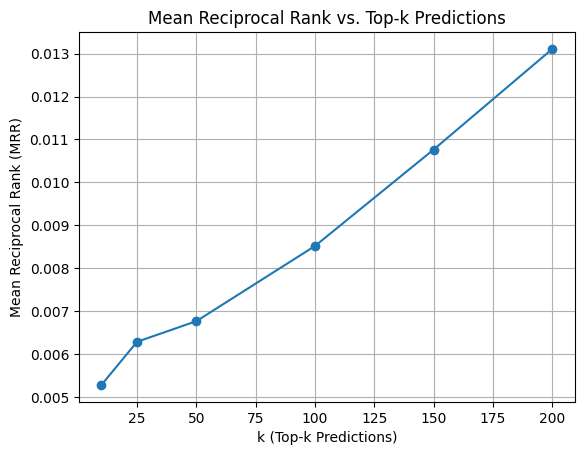

Target word:  shopping
200 25.669140293481753
Number of tokens:  503
shopping {10: 0.045652276815298695, 25: 0.04780299301911052, 50: 0.04910652765020173, 100: 0.050210840854192446, 150: 0.050772221543369564, 200: 0.051032088058611834}


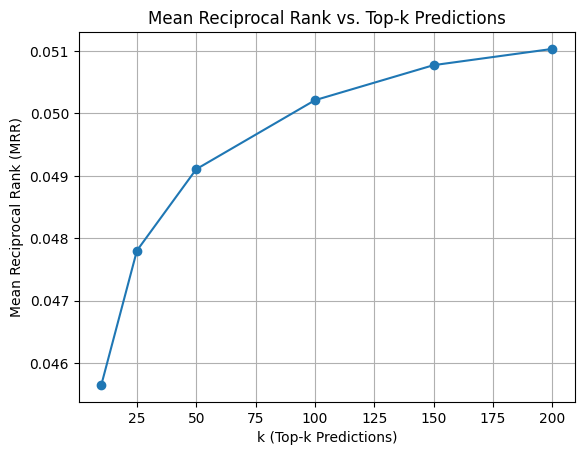

In [ ]:
import matplotlib.pyplot as plt
import csv

for word in words:

  print('Target word: ',word)

  with open('Sentence_Datasets/'+word+'_'+language+'_unique.txt','r') as final_list:
    sentences = final_list.readlines()
    sentences = [str(sentence.strip()) for sentence in sentences if sentence.strip()]  # skip empty lines
    sentences = sentences[:2000]

  mrr_results = {k: [] for k in range(1,max_k+1)} # initiating dictionary for each word
  m_retrieval = {k: [] for k in range(1,max_k+1)}

  if word in alternative_spellings.keys(): # checking if there are alternative spellings and adding these to be masked
    target_words = [word,word+'s',alternative_spellings[word],alternative_spellings[word]+'s']
  else:
    target_words = [word,word+'s']

  # tokenise target word, plurals and alternative spellings
  target_tokens = []
  for target in target_words:
    if tokenizer.tokenize(target.lower()) not in target_tokens: # alternative spellings may be same when tokenised
      target_tokens += [tokenizer.tokenize(target.lower())] # producing a list of tuples of tokens, where each tuple is a word

  if model_name == "camembert":
    stripped_tokens = []
    for item in target_tokens:
      item = [l.strip('▁') for l in item]
      if item[-1]=='s' and item[0] != '':
        if item[:-1] not in stripped_tokens:
          stripped_tokens +=[item[:-1]]
      elif item[-1]=='s' and item[0] == '':
        if item[1:-1] not in stripped_tokens:
          stripped_tokens +=[item[1:-1]]
      elif item[0]=='':
        if [item[1]] not in stripped_tokens:
          stripped_tokens += [[item[1]]]
      elif item:
        if item not in stripped_tokens:
          stripped_tokens +=[item]

  else:
    stripped_tokens = []
    for item in target_tokens:
      if item[-1]=='s':
        if item[:-1] not in stripped_tokens:
          stripped_tokens+=[item[:-1]]
      elif item not in stripped_tokens:
        stripped_tokens += [item]

  token_instances = 0 # initiating variable for number of instances to calculate mean

  for sentence in sentences:

    input_tensor,attention_mask_tensor,target_indices = pre_process_sentence(sentence,target_tokens)

    token_instances += len(target_indices) # adding the number of tokens
    # print('Sentence number: ',sentences.index(sentence),'Number of masked tokens:',len(target_indices))
    if token_instances >= (500*len(stripped_tokens[0])):
      break

    # for k in k_values:

    predictions = get_predicted_words(input_tensor,attention_mask_tensor,target_indices,model,tokenizer,max_k)

    for i in target_indices[::len(target_tokens[0])]: #iterating over start of every word
      if len(predictions[i])==0:
        continue
      else:
        # for item in stripped_tokens:
        for j in range(len(stripped_tokens)): # iterating over [['de', 'pan', 'neur'], ['dép', 'anne', 'ur'], ['dép', 'anne', 'urs']]
          # length = 0
          ranks = []
          for l in range(i,i+len(stripped_tokens[j])): # e.g. range(7,10), 7,8,9
            if l in predictions.keys(): # e.g. 7
              if stripped_tokens[j][l-i] in predictions[l]: # e.g. stripped_tokens[0][0] in predictions[7]
                ranks += [predictions[l].index(stripped_tokens[j][l-i])+1]
                # rank = predictions[l].index(stripped_tokens[j][l-i])
                # ranks += 1.0 / (rank + 1)
                # length += 1
          if len(ranks) == len(stripped_tokens[j]): #checking that all the sub-tokens are ranked
            for k in range(1,max_k+1):
              for rank in ranks:
                if rank<k:
                  mrr_results[k] += [1/rank]

  # Calculate mean MRR for all tokens and k values
  for m in range(1,max_k+1):
    if len(mrr_results[m]) != 0:
      m_retrieval[m] = (len(mrr_results[m]))/token_instances
      mrr_results[m] = (sum(mrr_results[m]))/token_instances
    else:
      mrr_results[m] = 0
      m_retrieval[m] = 0

  print('Number of tokens: ',token_instances)
  print(word,mrr_results)


  with open('Results/MLM_Results/masked_word_+'+model_name+'_'+language+'_v3.csv','a') as MRR:
    guesseswriter = csv.writer(MRR)
    values = [word,types[word]]
    for m in mrr_results.values():
      values.append(m)
    guesseswriter.writerow(values)

  with open('Results/MLM_Results/mean_retreival_'+model_name+'.csv','a') as MRET:
    retrievalwriter = csv.writer(MRET)
    retrievals = [word,types[word]]
    for n in m_retrieval.values():
      retrievals.append(n)
    retrievalwriter.writerow(retrievals)

  # Plotting retrieval
  plt.plot(range(1,max_k+1), m_retrieval.values(), marker='o')
  plt.xlabel('k (Top-k Predictions)')
  plt.ylabel('Mean Retreival Rank')
  plt.title('Mean Retrieval vs. Top-k Predictions')
  plt.grid(True)
  plt.show()

